# Project Overview

For this exploratory data project, I will be looking at a curated dataset of abalone measurements, with a goal of identifying a specimen's age (indicated by the Rings count). I have zero knowledge of abalone sizes, shapes, or any other characteristics, really. Thanks to my good friends at Wikipedia, I've managed to learn the following things about abalone:  

* Abalone are marine snails.
* The shells of abalones have a low, open spiral structure, and are characterized by several open respiratory pores in a row near the shell's outer edge.
* The shells are attractive to humans as decorative objects, jewelry, and as a source of colorful mother-of-pearl.
* The flesh of abalones is widely considered to be a desirable food, and is consumed raw or cooked by a variety of cultures.

Thank you for coming to my abalone Ted Talk. Let's look at some data!

In [128]:
#pip install seaborn --upgrade
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

Since we're just doing exploratory analysis on this data, I'm going to keep a to-do list of clean-up tasks. This will allow us to analyze the raw data but maintain a record of what we know needs attention.

In [2]:
todo = set()

# Data Dictionary

|Atrribute Name|Definition|Example|
|---|---|---|
|Sex | Sex (M: Male, F: Female, I: Infant) | "M", "F", "I"  
|Length | Longest Shell measurement (mm) | 0.530, 0.440, 0.425  
|Diameter | Diameter - perpendicular to length (mm) | 0.350, 0.380, 0.300  
|Height | Height - with meat in shell (mm) | 0.095, 0.150, 0.110  
|Whole weight | Weight of whole abalone (grams) | 0.5140, 0.2255, 0.6845  
|Shucked weight | Weight of meat (grams) | 0.1940, 0.1675, 0.0975  
|Viscera weight | Gut weight after bleeding (grams) | 0.1010, 0.1495, 0.0490  
|Shell weight | Shell weight - after being dried (grams) | 0.330, 0.115, 0.245  
|Rings | Rings - value + 1.5 gives age in years (eg. 4 = 5.5 years) | 19, 8, 29  

In [3]:
df = pd.read_csv('abalone.data.csv', header=None, names=('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings'))

In [4]:
df.shape

(4177, 9)

Our data is 4,177 rows and 9 columns. Let's take a look at the columns to see if our data types look correct.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole_weight    4177 non-null   float64
 5   shucked_weight  4177 non-null   float64
 6   viscera_weight  4177 non-null   float64
 7   shell_weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


# Outliers & Weird Stuff

Now that we've confirmed our data is structurally sound, it's time to start digging into the values.

In [6]:
df.describe()

length     diameter       height  whole_weight  shucked_weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       viscera_weight  shell_weight        rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.000000  
50%          0.171000      0.234000     9.000000  
75%          0.253000      0.329000    11.000000  
max          0.760000      1.005000    29.000000

Right away, a minimum height of 0.00 seems incorrect. That's probably going to come back later so let's add it to the list of things to look at.

In [7]:
todo.add('height 0.00')

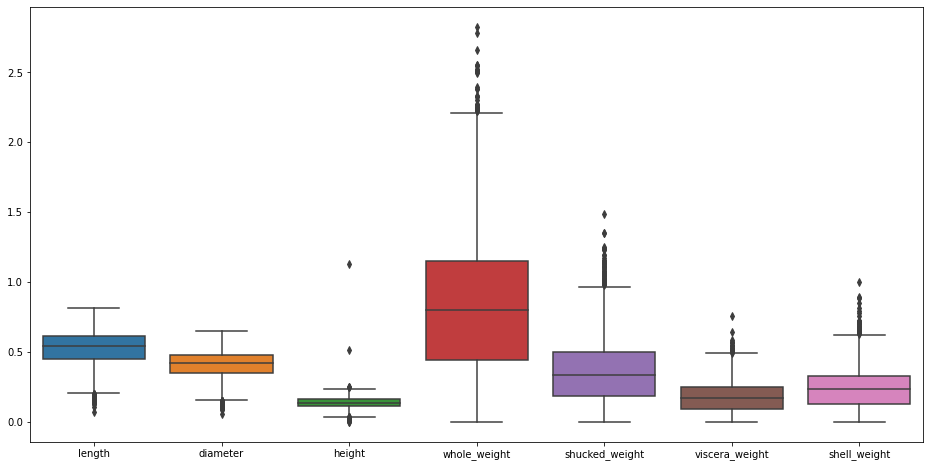

In [8]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight']])

Our length, diameter, and height means are all smaller than their respective medians, indicating the data will be left-skewed. Conversely, our weight values all appear to be right-skewed. We're also showing outliers beyond the IQR fence for height, whole_weight, shucked_weight, viscera_weight, and shell_weight. We will address these issues later. For now, let's look at our single categorical variable.

## Sex

In [9]:
df['sex']

0       M
1       M
2       F
3       M
4       I
       ..
4172    F
4173    M
4174    M
4175    F
4176    M
Name: sex, Length: 4177, dtype: object

Right away, we find an interesting distinction in the data. Our sexes are Male, Female, and Infant. This is presumably because identifying the sex of Infants is difficult. Let's take a look at the data breakdown to find out just how many infants we're dealing with.

In [10]:
df[df['sex'].isna()]

Empty DataFrame
Columns: [sex, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, rings]
Index: []

No missing data. That's good.

In [11]:
#A quick and dirty way to generate percentages
df['sex'].value_counts(normalize=True)

M    0.365813
I    0.321283
F    0.312904
Name: sex, dtype: float64

Infants are a significant amount of the data. We might need to dig into what exactly defines an infant later on. It's probably a safe assumption that infants will be smaller across the board (weight, length, height). Also, interesting to note is that males account for ~5.3% more entries than females. Without having gained any domain knowledge about abalone in the last 10 code blocks, it's hard to determine whether or not this is important. Let's visualize the data for clarity's sake.

In [12]:
todo.add('Sex: What defines Infant?')

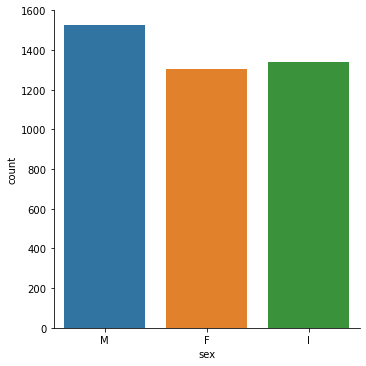

In [13]:
sns.catplot(x='sex', data = df, kind="count")

## Length

Our first numerical value is length. Since this value is numeric, we will look at a histogram to get an idea of how the data is distributed. If we were just looking at adults, we would probably have a normal distribution (maybe? male female split in our data isn't 50/50). We've already determined the data will be left skewed, most likely due to the infant classification.

In [14]:
df['length'].describe()

count    4177.000000
mean        0.523992
std         0.120093
min         0.075000
25%         0.450000
50%         0.545000
75%         0.615000
max         0.815000
Name: length, dtype: float64

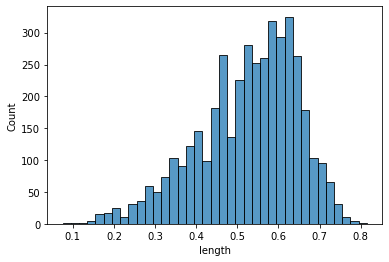

In [15]:
sns.histplot(x='length', data=df)

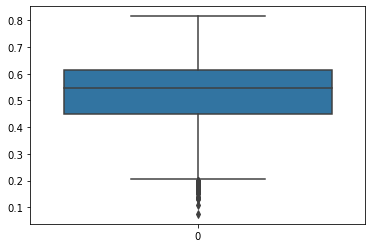

In [16]:
sns.boxplot(data=df['length'])

Here we're showing outlier data on the low-end. This is probably due to all of the infants recorded, but we can't say for certain.

In [17]:
todo.add('Length Outliers')

<function matplotlib.pyplot.show(*args, **kw)>

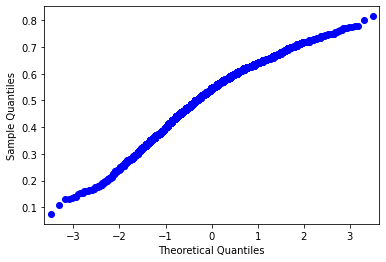

In [18]:
sm.qqplot(df['length'])
plt.show

Our QQ plot shows a relatively normal distribution.

## Diameter

Another numerical variable. We'll do essentially the same thing as we did for length.

In [19]:
df['diameter'].describe()

count    4177.000000
mean        0.407881
std         0.099240
min         0.055000
25%         0.350000
50%         0.425000
75%         0.480000
max         0.650000
Name: diameter, dtype: float64

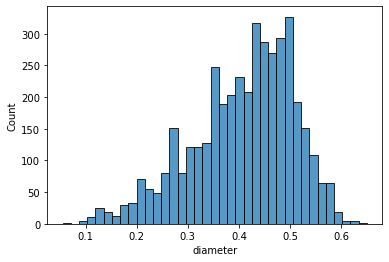

In [20]:
sns.histplot(x='diameter', data=df)

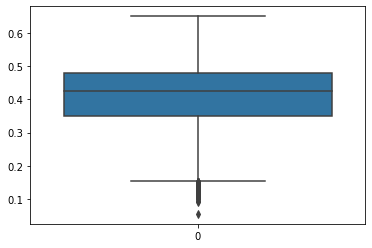

In [21]:
sns.boxplot(data=df['diameter'])

More low-end outliers.

In [22]:
todo.add('Diameter outliers')

<function matplotlib.pyplot.show(*args, **kw)>

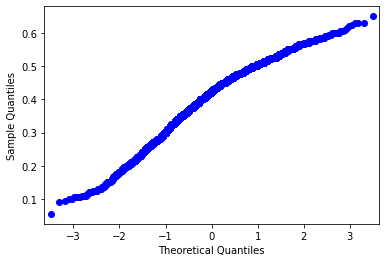

In [23]:
sm.qqplot(df['diameter'])
plt.show

Again, our QQ plot shows a relatively normal distribution.

## Height

In [24]:
df['height'].describe()

count    4177.000000
mean        0.139516
std         0.041827
min         0.000000
25%         0.115000
50%         0.140000
75%         0.165000
max         1.130000
Name: height, dtype: float64

There's our 0.00 height value again. Definitely going to have to take a look at that.

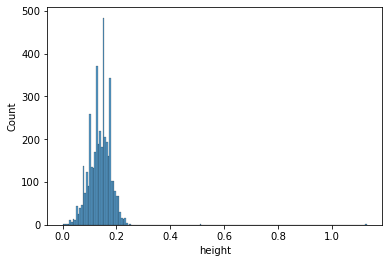

In [25]:
sns.histplot(x='height', data=df)

That max height is really messing with our histogram.

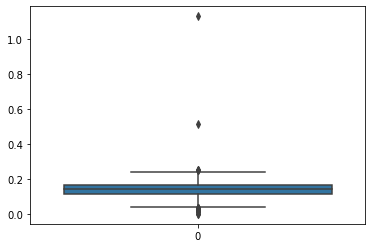

In [26]:
sns.boxplot(data=df['height'])

<function matplotlib.pyplot.show(*args, **kw)>

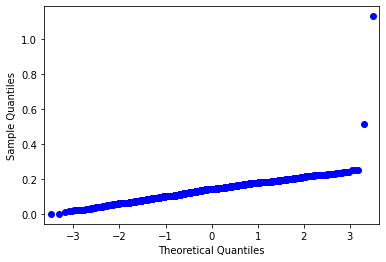

In [27]:
sm.qqplot(df['height'])
plt.show

A couple outlier data points definitely causing problems. Add reviewing it to the todo list.

In [28]:
todo.add('Max Height Review')

## Weight

Weight requires at least one definition of a word I don't know. viscera - the internal organs in the main cavities of the body, especially those in the abdomen, e.g. the intestines.  

The weight values are essentially listed as whole, meat, innards, shell.  In theory, the meat, innards, and shell should add up to the whole_weight. We'll check later if that's true across the board. It's also highly possible the sum of the parts won't equal the whole.

In [29]:
df[['whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight']].describe()

whole_weight  shucked_weight  viscera_weight  shell_weight
count   4177.000000     4177.000000     4177.000000   4177.000000
mean       0.828742        0.359367        0.180594      0.238831
std        0.490389        0.221963        0.109614      0.139203
min        0.002000        0.001000        0.000500      0.001500
25%        0.441500        0.186000        0.093500      0.130000
50%        0.799500        0.336000        0.171000      0.234000
75%        1.153000        0.502000        0.253000      0.329000
max        2.825500        1.488000        0.760000      1.005000

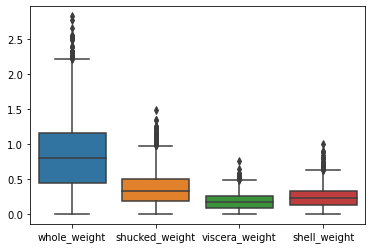

In [30]:
sns.boxplot(data=df[['whole_weight','shucked_weight','viscera_weight','shell_weight']])

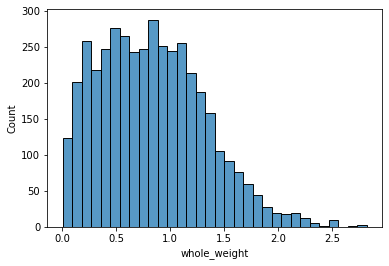

In [31]:
sns.histplot(x='whole_weight', data=df)

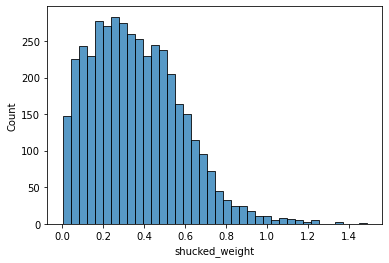

In [32]:
sns.histplot(x='shucked_weight', data=df)

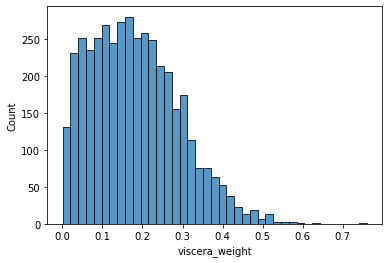

In [33]:
sns.histplot(x='viscera_weight', data=df)

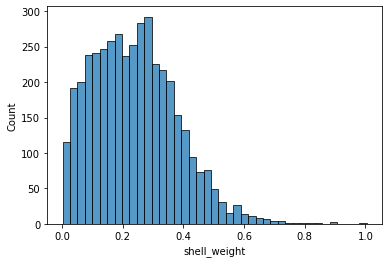

In [34]:
sns.histplot(x='shell_weight', data=df)

Since we have multiple weight values, it's worth looking at whether or not the measurements are all correct. We have a "whole_weight" value that should always be greater than any of the other weight values for a particular sample. Let's double-check that this true.

In [35]:
df[df['whole_weight'] < df['shucked_weight']]

sex  length  diameter  height  whole_weight  shucked_weight  \
1216   I   0.310     0.225   0.070        0.1055          0.4350   
2627   I   0.275     0.205   0.070        0.1055          0.4950   
2641   I   0.475     0.365   0.100        0.1315          0.2025   
3086   I   0.355     0.270   0.075        0.2040          0.3045   

      viscera_weight  shell_weight  rings  
1216          0.0150        0.0400      5  
2627          0.0190        0.0315      5  
2641          0.0875        0.1230      7  
3086          0.0460        0.0595      7

Well....that's not right.

In [36]:
df[df['whole_weight'] < df['viscera_weight']]

Empty DataFrame
Columns: [sex, length, diameter, height, whole_weight, shucked_weight, viscera_weight, shell_weight, rings]
Index: []

In [37]:
df[df['whole_weight'] < df['shell_weight']]

sex  length  diameter  height  whole_weight  shucked_weight  \
3996   I   0.315      0.23     0.0         0.134          0.0575   

      viscera_weight  shell_weight  rings  
3996          0.0285        0.3505      6

In [38]:
todo.add('Shucked_weight > whole_weight')
todo.add('Shell_weight > whole_weight')

Let's make one exploratory feature to look at how far off our calculation results are. If we have negative values for this feature, it's going to show that the individually recorded values for the abalone components account or more weight than the actual weight. This indicates a data problem.

In [39]:
df['lost_weight'] = df['whole_weight'] - df['shucked_weight'] - df['viscera_weight'] - df['shell_weight']

In [40]:
df['lost_weight'].sort_values(ascending=True).head(30)

3518   -0.4475
2627   -0.4400
1216   -0.3845
2084   -0.3370
3996   -0.3025
2707   -0.2985
2641   -0.2815
2790   -0.2805
1419   -0.2750
2854   -0.2170
3086   -0.2060
1264   -0.1735
3034   -0.1505
1302   -0.1430
1637   -0.1375
2127   -0.1350
3050   -0.1305
3814   -0.1220
1128   -0.1170
1574   -0.1020
1391   -0.0915
193    -0.0820
46     -0.0805
3471   -0.0785
1412   -0.0685
3169   -0.0680
1252   -0.0675
822    -0.0675
2746   -0.0650
936    -0.0585
Name: lost_weight, dtype: float64

Let's see what's going on with the worst one there.

In [41]:
df.iloc[3518]

sex                    M
length              0.71
diameter            0.57
height             0.195
whole_weight       1.348
shucked_weight    0.8985
viscera_weight    0.4435
shell_weight      0.4535
rings                 11
lost_weight      -0.4475
Name: 3518, dtype: object

Always concerning when 1 + 1 doesn't equal 2. There's clearly some sort of measurement or recording issue here. How far off are the rest of the values?

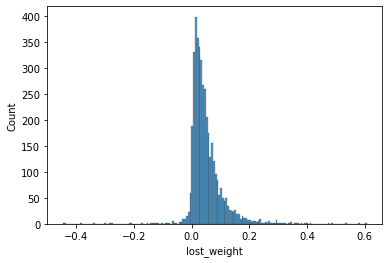

In [42]:
sns.histplot(x='lost_weight', data=df)

The results from this calculation might require some attention. The positive values could be bits and pieces lost during the shucking process. The negative values mean data was double (or triple) counted at the different weighing stages.

In [43]:
todo.add('Look at lost_weight extreme values, especially negative amounts.')

## Rings

Last, but definitely not least, let's look at our Rings. This, when combined with the formula described at the beginning of this notebook, will let us calculate an abalone's age. We know the Rings variable has integer values, so our graphs will look a little different.

In [44]:
df['rings'].describe()

count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: rings, dtype: float64

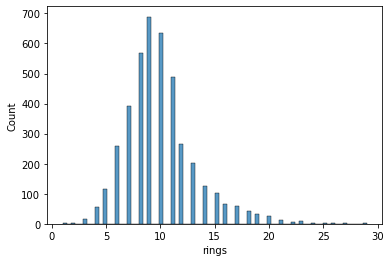

In [45]:
sns.histplot(x='rings', data=df)

Generally speaking, our data is normally distributed, although right-skewed.

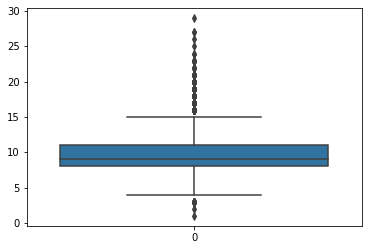

In [46]:
sns.boxplot(data=df['rings'])

Definitely some outliers to deal with.

## Pairwise Analysis

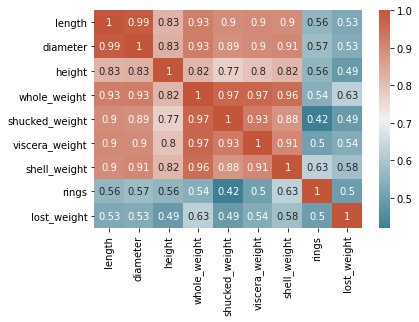

In [47]:
# calculate correlation matrix
corr = df.corr()# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Our heatmap shows EXTREMELY high positive correlation, almost across the board between features. Interestingly, none of them show strong correlation with our dependent variable, rings.

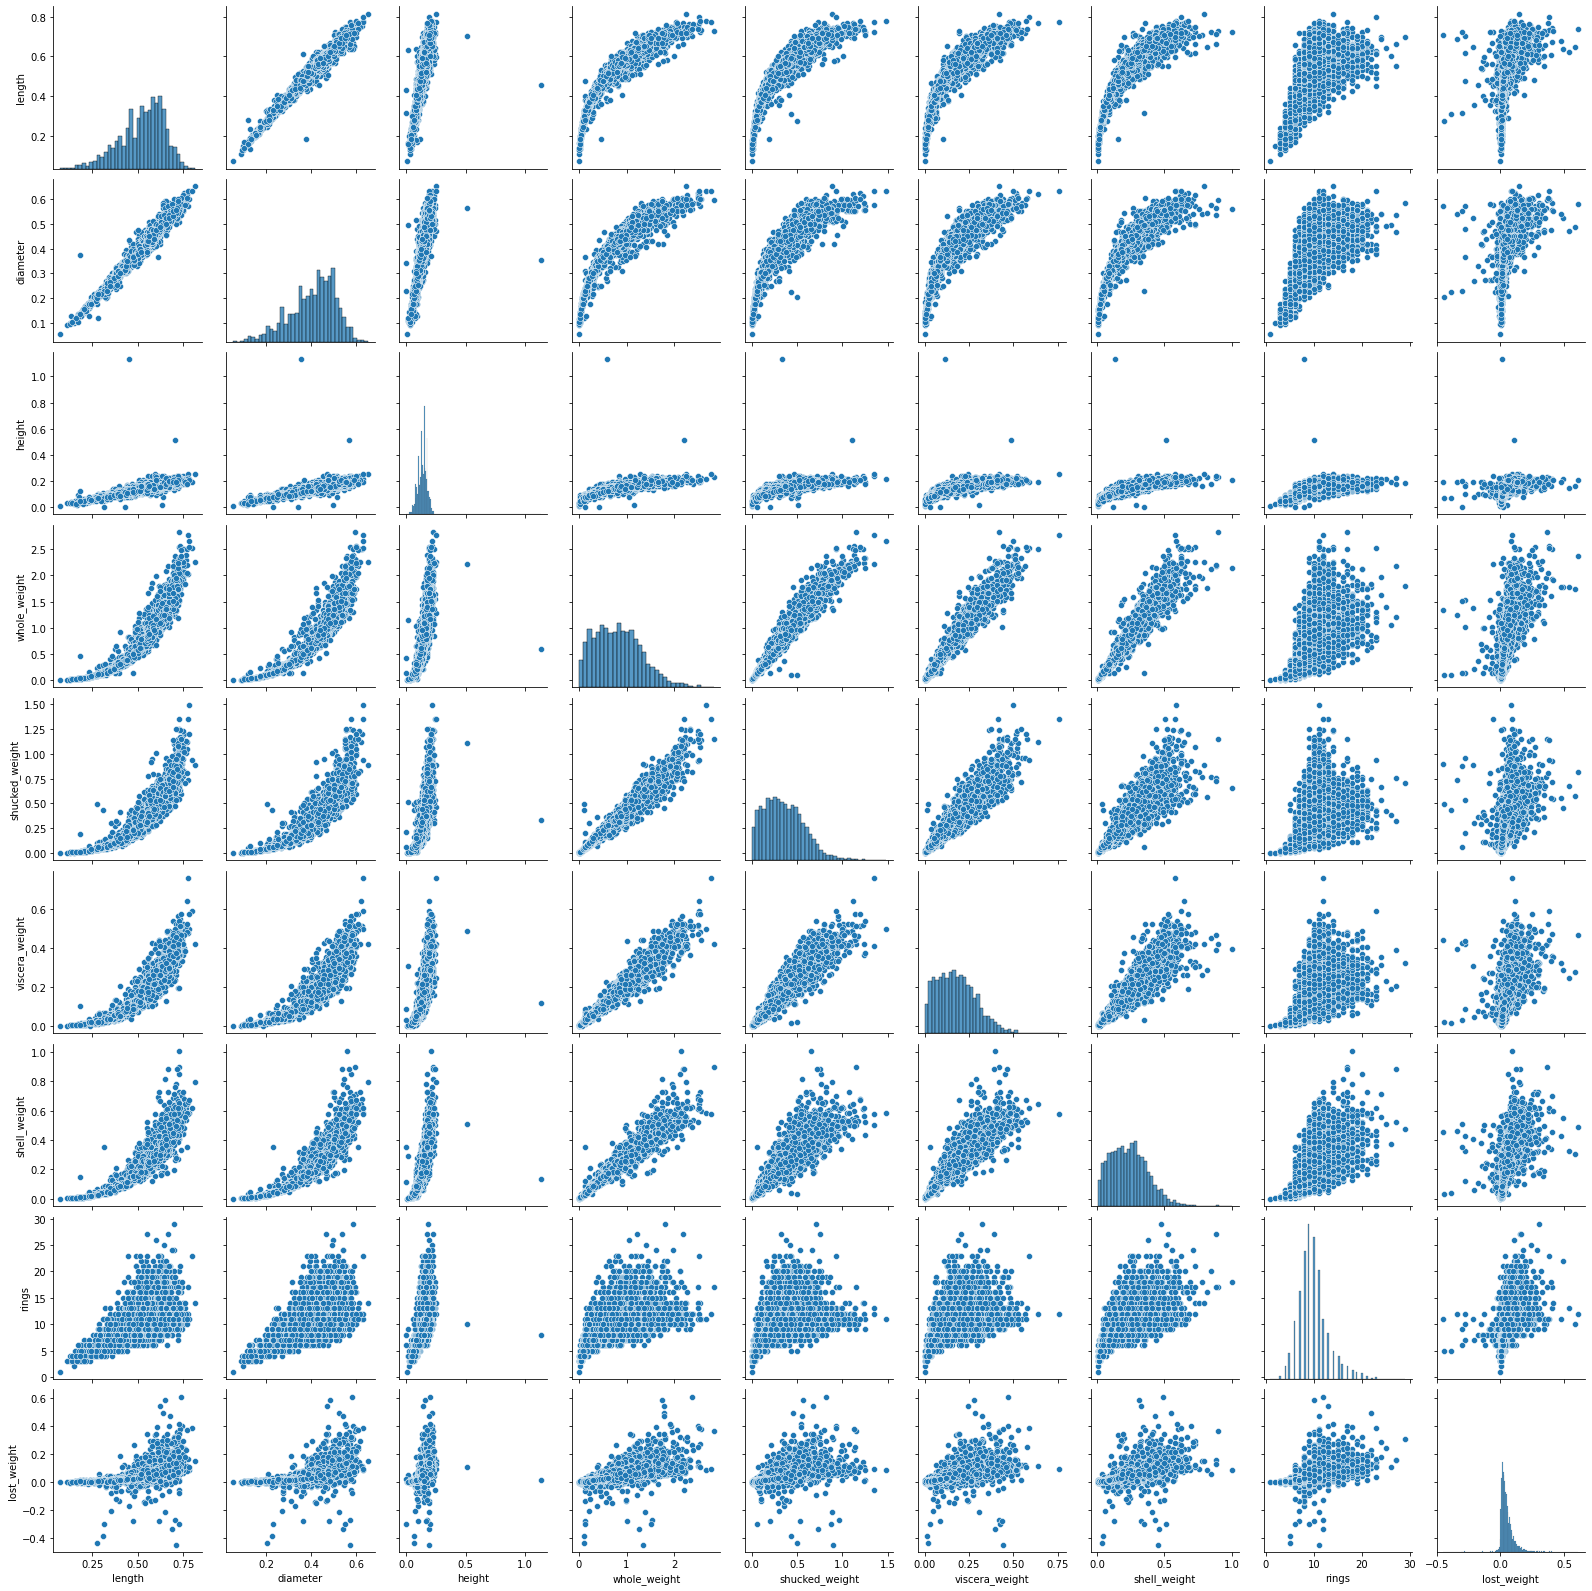

In [48]:
sns.pairplot(df)

The nice thing about the Seaborn pairplot is it gives us the histograms to refer to as well. In these plots, it's easy to see there are a couple height values throwing a wrench into the mix.

# Data Cleanup

Let's review the todo list and try to understand some of the strange data.

In [49]:
todo

{'Diameter outliers',
 'Length Outliers',
 'Look at lost_weight extreme values, especially negative amounts.',
 'Max Height Review',
 'Sex: What defines Infant?',
 'Shell_weight > whole_weight',
 'Shucked_weight > whole_weight',
 'height 0.00'}

I think, since we already know the situation with height, that might be the best place to start.

In [50]:
df[df['height'] == 0]

sex  length  diameter  height  whole_weight  shucked_weight  \
1257   I   0.430      0.34     0.0         0.428          0.2065   
3996   I   0.315      0.23     0.0         0.134          0.0575   

      viscera_weight  shell_weight  rings  lost_weight  
1257          0.0860        0.1150      8       0.0205  
3996          0.0285        0.3505      6      -0.3025

OK, two records with 0.0 height. Given that we have 4177 entries it's not the end of the world. Let's see if there are more small values.

In [51]:
df['height'].sort_values(ascending=True).head(20)

3996    0.000
1257    0.000
236     0.010
2169    0.015
1174    0.015
3902    0.020
694     0.020
1987    0.025
2381    0.025
3190    0.025
720     0.025
719     0.025
2171    0.030
238     0.030
2172    0.030
237     0.030
2711    0.030
306     0.030
718     0.035
1429    0.035
Name: height, dtype: float64

For these two entries we can do a couple things. We can either remove the entries entirely, we can impute a value (possibly either the mean or median) and replace the zero, or we could run the data through a knn and find similar entries and estimate/impute a value from those heights. Since we seem to have valid length and diameter values, I want to see if it would be reasonable to try to impute the values.

When doing knn imputation, we have to deal with a couple things. 

1. We have to have numerical values. Using the temp data method below, we'll read everything except Sex into a new dataframe and impute on that.
2. Our field currently has 0.000 as the value and for the knn imputation to work it needs to be na.
3. Our data needs to be similarly scaled so large values in one column of data don't throw things off. fit_transform will help with this.

In [52]:
#Our problem rows: 3996, 1257

from sklearn.impute import KNNImputer

df['height'].replace(0.000, pd.NA, inplace=True)

imputer = KNNImputer()
imputed_data = imputer.fit_transform(df[['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight','rings']])
df_temp = pd.DataFrame(imputed_data)
df_temp.columns = df[['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight','rings']].columns
df['height'] = df_temp['height']  # update only the desired column

df['height'].sort_values(ascending=True)


236     0.010
1174    0.015
2169    0.015
694     0.020
3902    0.020
        ...  
1763    0.250
1428    0.250
2179    0.250
1417    0.515
2051    1.130
Name: height, Length: 4177, dtype: float64

In [53]:
print(df.iloc[3996])

sex                    I
length             0.315
diameter            0.23
height             0.082
whole_weight       0.134
shucked_weight    0.0575
viscera_weight    0.0285
shell_weight      0.3505
rings                  6
lost_weight      -0.3025
Name: 3996, dtype: object


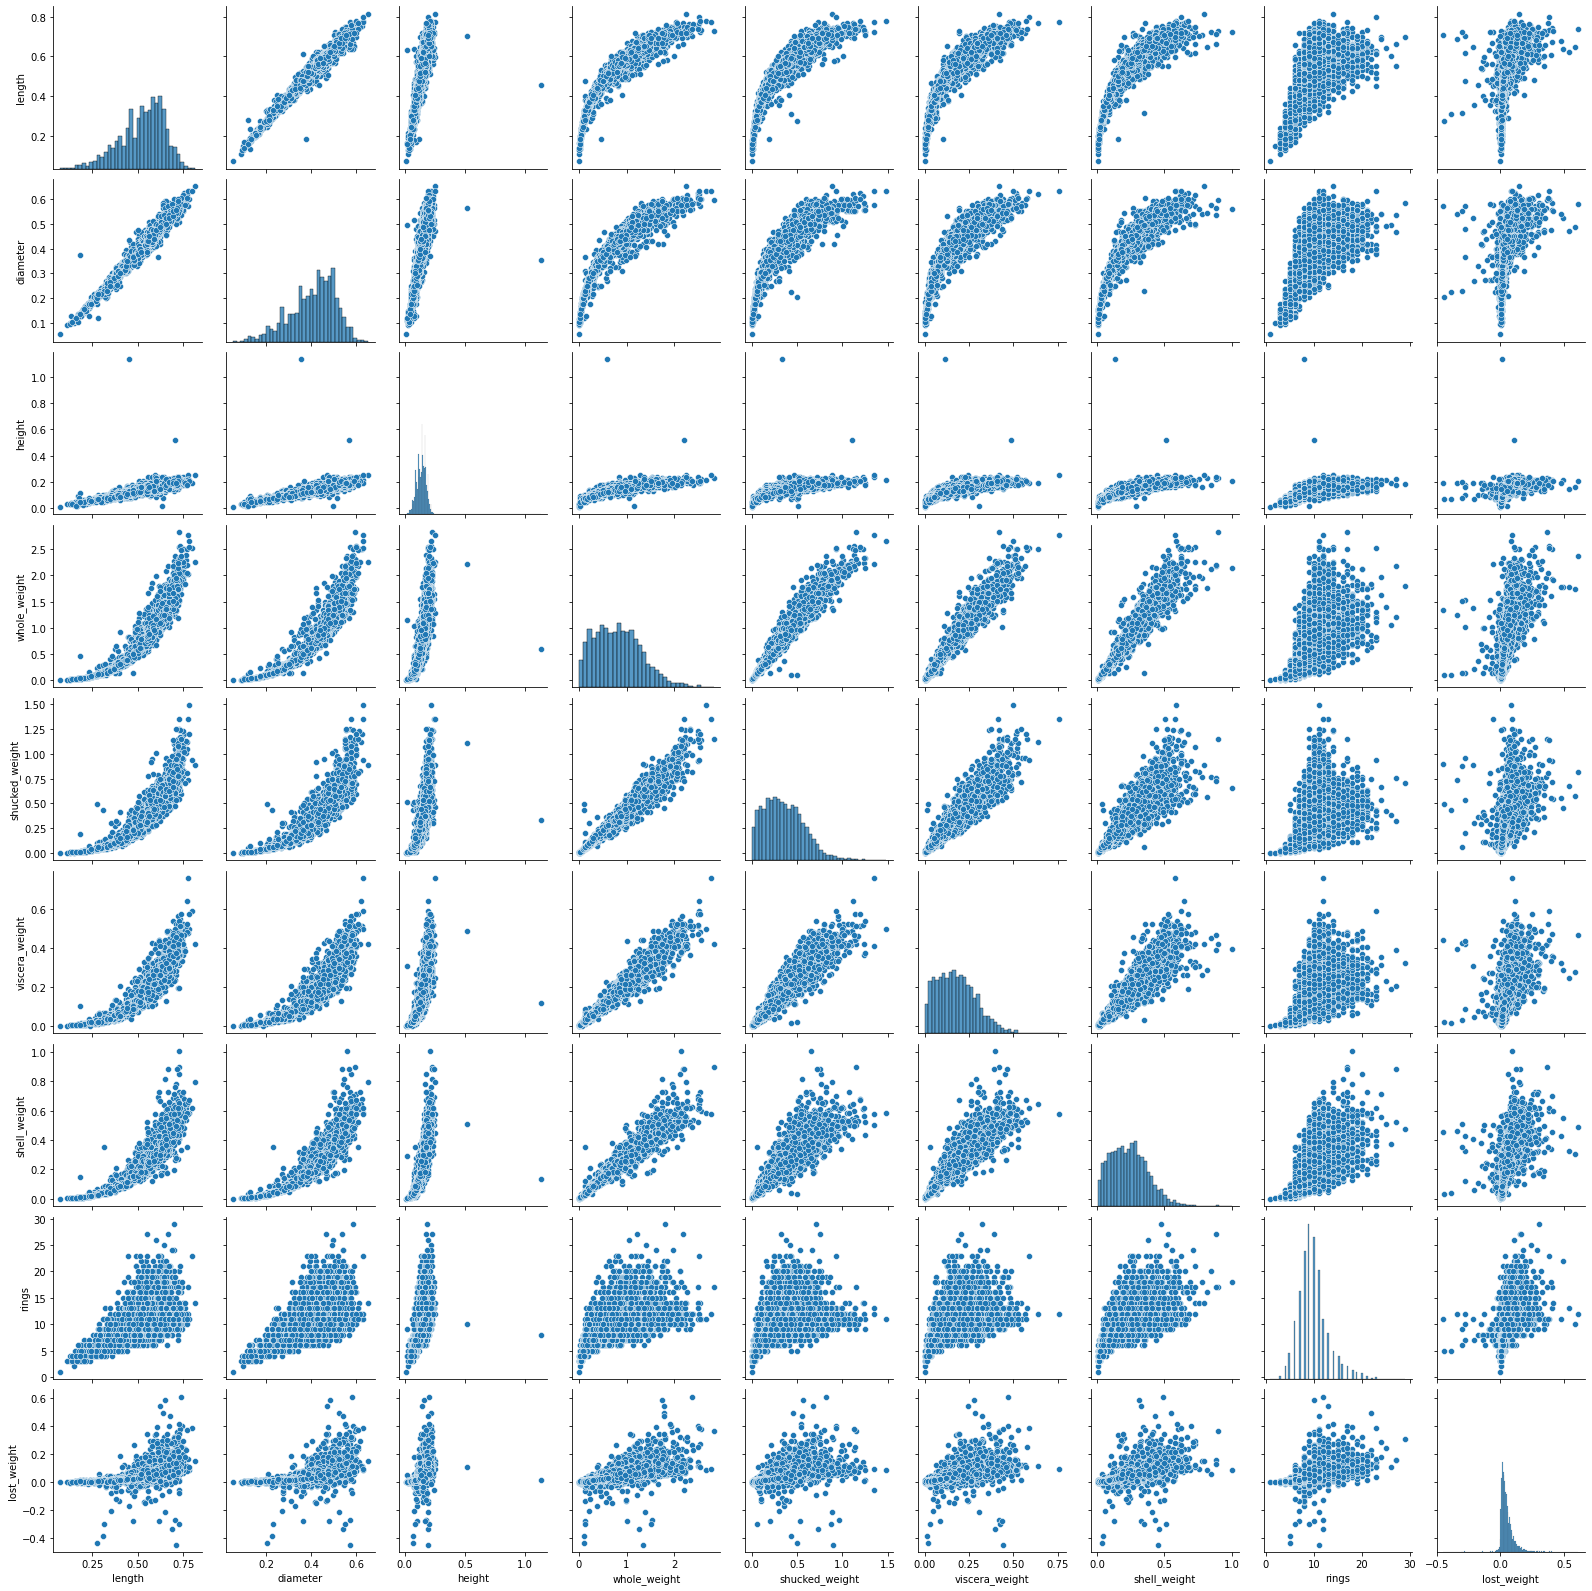

In [54]:
sns.pairplot(df)

Fixing the zero values didn't generate a lot of change in our pairwise plots. If we look at height, there are still two glaring data points that we should address. Let's see what's going on there.  But first, let's check something off our to do list!

In [55]:
todo

{'Diameter outliers',
 'Length Outliers',
 'Look at lost_weight extreme values, especially negative amounts.',
 'Max Height Review',
 'Sex: What defines Infant?',
 'Shell_weight > whole_weight',
 'Shucked_weight > whole_weight',
 'height 0.00'}

In [56]:
todo.remove('height 0.00')

In [57]:
todo

{'Diameter outliers',
 'Length Outliers',
 'Look at lost_weight extreme values, especially negative amounts.',
 'Max Height Review',
 'Sex: What defines Infant?',
 'Shell_weight > whole_weight',
 'Shucked_weight > whole_weight'}

OK, back to real work.

In [58]:
df['height'].sort_values(ascending=False).head(10)

2051    1.130
1417    0.515
2179    0.250
1428    0.250
1763    0.250
277     0.240
307     0.240
1528    0.240
2161    0.240
2212    0.235
Name: height, dtype: float64

In [59]:
df.iloc[[2051, 1417, 2179], ]

sex  length  diameter  height  whole_weight  shucked_weight  \
2051   F   0.455     0.355   1.130         0.594          0.3320   
1417   M   0.705     0.565   0.515         2.210          1.1075   
2179   F   0.595     0.470   0.250         1.283          0.4620   

      viscera_weight  shell_weight  rings  lost_weight  
2051          0.1160        0.1335      8       0.0125  
1417          0.4865        0.5120     10       0.1040  
2179          0.2475        0.4450     14       0.1285

Even next to another entry of similar length and diameter, these points stil look grossly off. The recorded values might be off, but they're so far away from the other data points I think I'm just going to remove them.

In [60]:
df.drop(2051, inplace=True)
df.drop(1417, inplace=True)

In [61]:
df['height'].sort_values(ascending=False).head(10)

2179    0.250
1763    0.250
1428    0.250
2161    0.240
1528    0.240
307     0.240
277     0.240
506     0.235
3993    0.235
2212    0.235
Name: height, dtype: float64

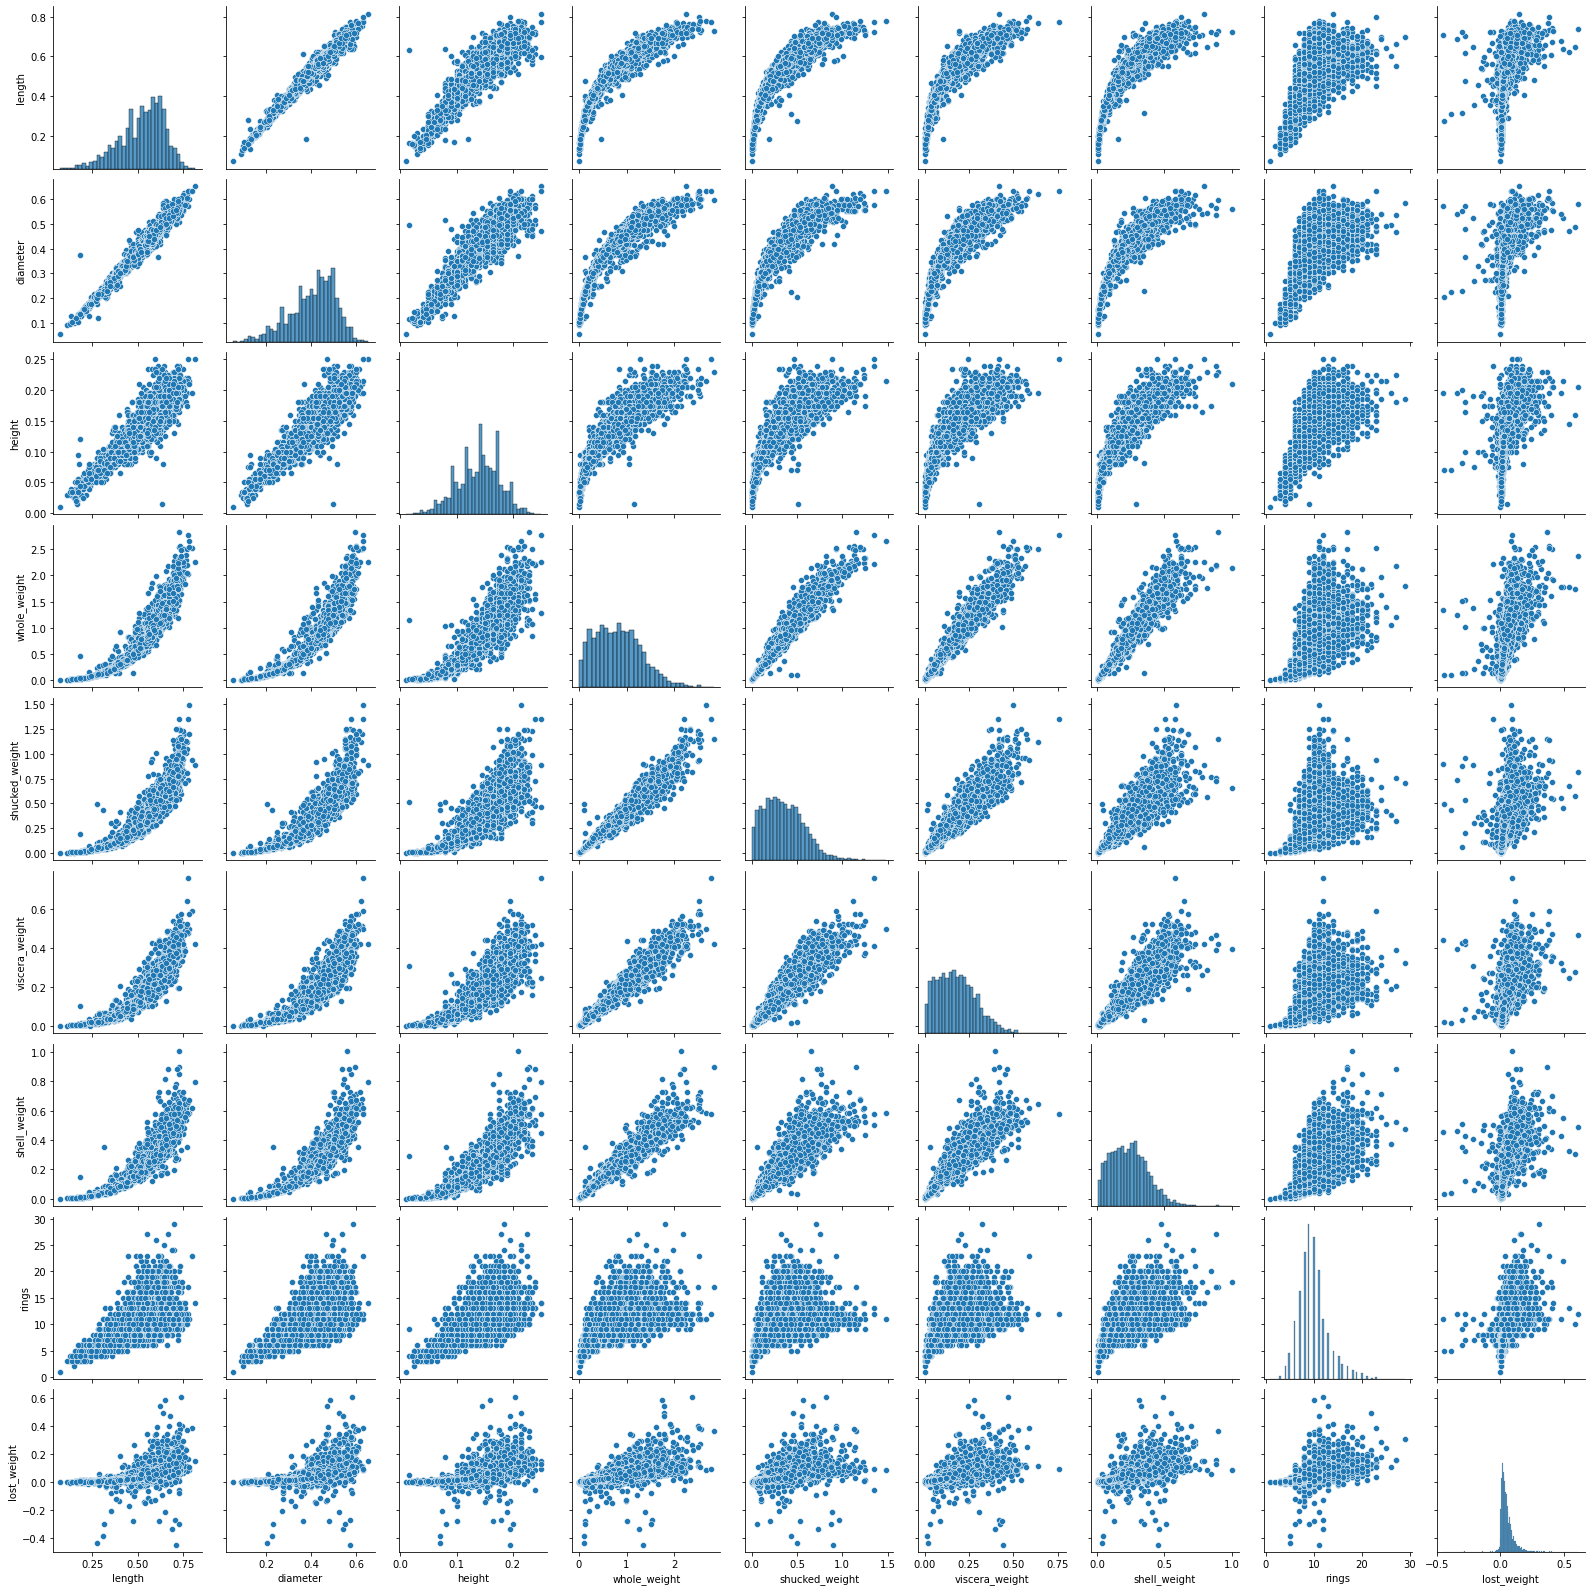

In [62]:
sns.pairplot(df)

In [63]:
todo.remove('Max Height Review')

In [64]:
todo

{'Diameter outliers',
 'Length Outliers',
 'Look at lost_weight extreme values, especially negative amounts.',
 'Sex: What defines Infant?',
 'Shell_weight > whole_weight',
 'Shucked_weight > whole_weight'}

As we already determined from the pairwise comparison and correlation, the additional weight breakdowns don't really bring much to the table on their own and, in some cases, create more questions than they answer. Let's stick with total weight as the best indicator and remove the others.

In [65]:
df.drop(['shucked_weight', 'viscera_weight', 'shell_weight', 'lost_weight'], axis=1, inplace=True)

In [66]:
todo.remove('Shell_weight > whole_weight')
todo.remove('Shucked_weight > whole_weight')
todo.remove('Look at lost_weight extreme values, especially negative amounts.')

In [67]:
todo

{'Diameter outliers', 'Length Outliers', 'Sex: What defines Infant?'}

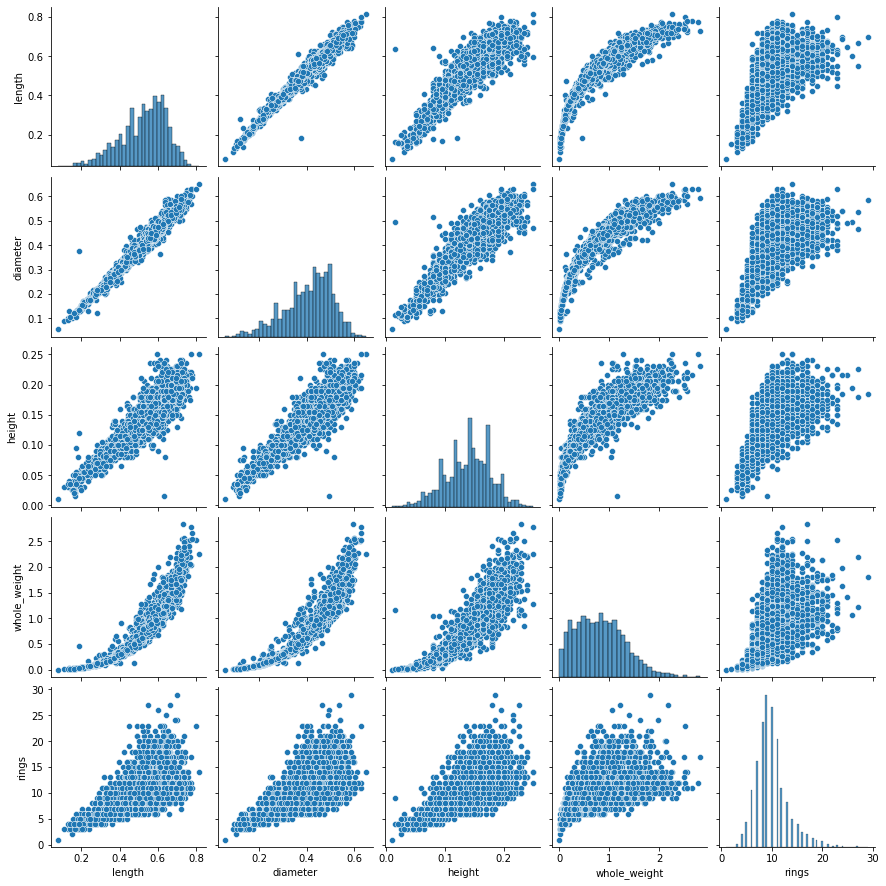

In [68]:
sns.pairplot(df)

We still have a couple stray points. Let's try and identify them.

In [69]:
df[(df['height'] < .05) & (df['diameter'] > .4)]

sex  length  diameter  height  whole_weight  rings
1174   F   0.635     0.495   0.015        1.1565      9

Something about that data point smells funny to me. I'm going to remove it.

In [70]:
df.drop(1174, inplace=True)

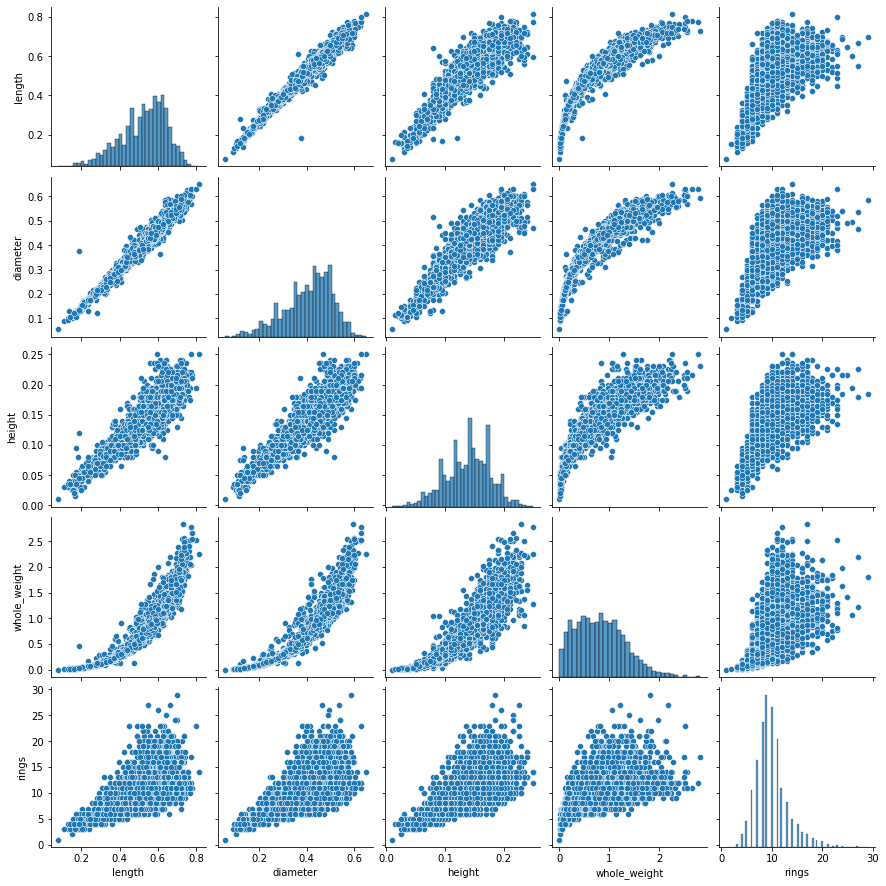

In [71]:
sns.pairplot(df)

In [72]:
df[(df['length'] < .3) & (df['diameter'] > .3)]

sex  length  diameter  height  whole_weight  rings
1210   I   0.185     0.375    0.12        0.4645      6

In [73]:
df.drop(1210, inplace=True)

In [74]:
todo.remove('Diameter outliers')

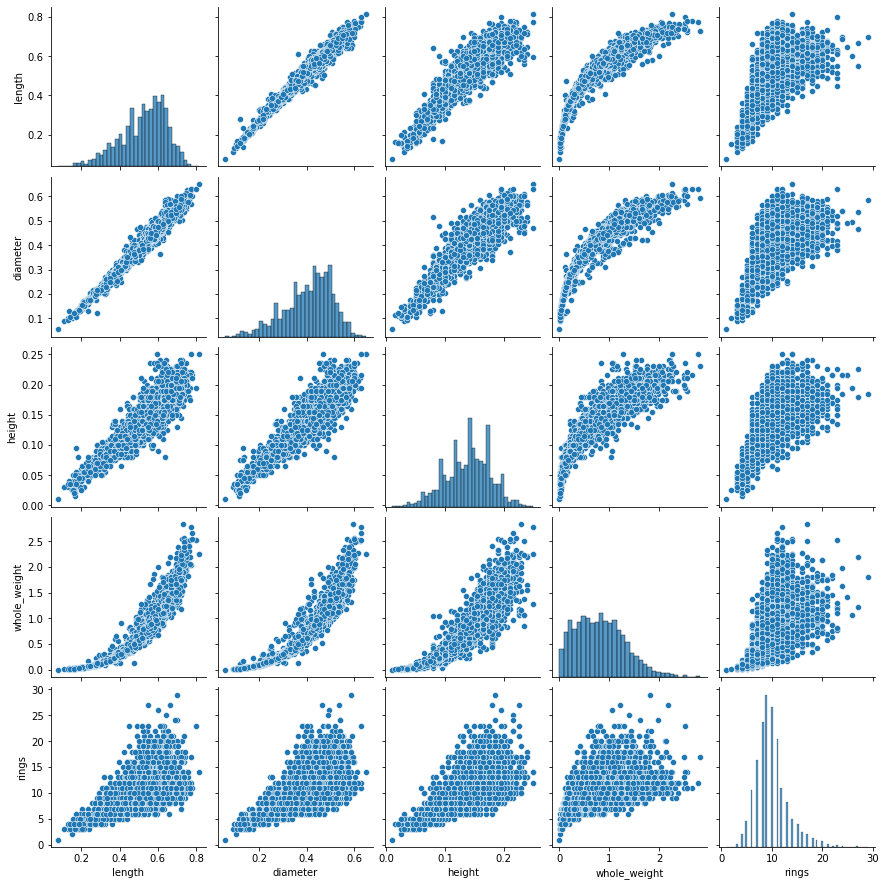

In [75]:
sns.pairplot(df)

Our todo list has dealing with small height values, but we also still need to understand what infants mean. It could be possible we're combining two datasets that could really stand on their own. What if we look at our pairplots and separate out by "sex"?

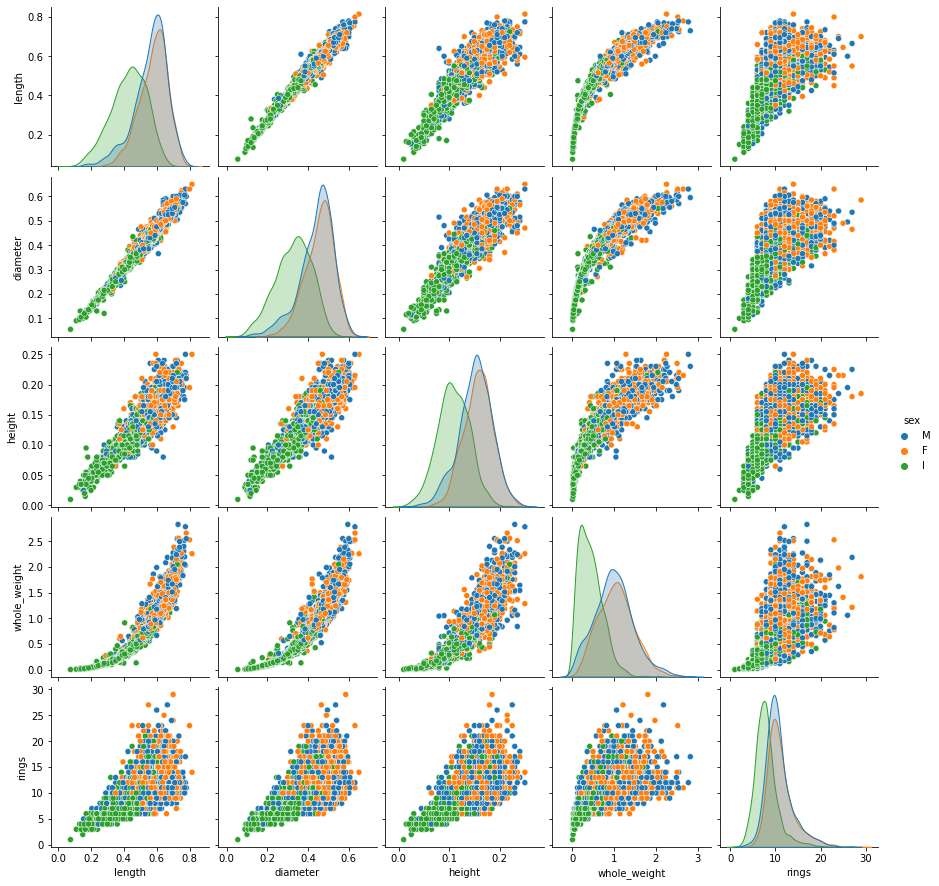

In [76]:
sns.pairplot(df, hue='sex')

It's clear that Infant values definitely dominate the lower end of the data spectrum. Males and females are split pretty evenly so it seems like we really are dealing with two distinct sets of data. Without knowing the ramifications of classifying a small male/female as an infant, or a large infant as a male/female, I think we should leave the data as-is for the moment.

In [77]:
todo.remove('Length Outliers')
todo.remove('Sex: What defines Infant?')
todo

set()

To do empty, some data cleaned up, some pretty good visualizations. I think this data is ready to roll.

# Modeling (WORK IN PROGRESS)

For this dataset, we're going to look at predicting a value, Rings, that will help us identify the age of an abalone. This can be approached a couple of ways. Since we're dealing with predicting a value, we can use regression. The value we're trying to predict is integer-based so we could also treat it as a classification problem. (A cheat sheet on how to pick the type of algorithms to use for a particular problem can be found here: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

There's one small issue we haven't dealt with in our dataset yet. Our Sex variable is currently categorical and that won't work for doing regression. If we were dealing with ordinal data (jr., sr., III, IV) we could use label encoding and retain the idea that Sr. is "greater than" Jr. For our data, M/F/I are all going to be considered equals. To do this, we will one-hot encode them.

*Read Invisible Women by Caroline Criado Perez https://smile.amazon.com/Invisible-Women-Data-World-Designed/dp/1419729071 if you're interested in how males and females have traditionally been treated by data.

In [90]:
# importing one hot encoder 
from sklearn.preprocessing import OneHotEncoder

# Since we've done some manipulation, let's reset our index values so they're sequential. This will make sure we don't run into errors later on.
df = df.reset_index(drop=True)

# creating one hot encoder object 
onehotencoder = OneHotEncoder()

# #To add this back into the original dataframe 
dfOneHot = pd.DataFrame(onehotencoder.fit_transform(df[['sex']]).toarray())
df = pd.concat([df, dfOneHot], axis=1)

# #droping the country column 
df.columns = ['sex', 'length', 'diameter', 'height', 'whole_weight', 'rings', 'sexF', 'sexI', 'sexM']
df = df.drop(['sex'], axis=1)
df = df.drop(['sexF'], axis=1)

#printing to verify 
print(df.head())

   length  diameter  height  whole_weight  rings  sexI  sexM
0   0.455     0.365   0.095        0.5140     15   0.0   1.0
1   0.350     0.265   0.090        0.2255      7   0.0   1.0
2   0.530     0.420   0.135        0.6770      9   0.0   0.0
3   0.440     0.365   0.125        0.5160     10   0.0   1.0
4   0.330     0.255   0.080        0.2050      7   1.0   0.0


In [91]:
from sklearn.model_selection import train_test_split

In [92]:
y = df['rings']
x = df[['length', 'diameter', 'height', 'whole_weight', 'sexI', 'sexM']]

In [93]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=1738)

### Decision Tree

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)

In [119]:
y_pred = clf.predict(x_test)

In [122]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division='warn'))

[[ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8  5  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  4 14  0  7  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0 40  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0 41 19 27  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 16 27 64  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  5 20 78 22  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  6 68 38  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  2 43 28 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 30 11  6  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2 16 11  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 14  2  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  2 18  2  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  6  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  3  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0

**Terminology Refresher**
  
* Precision - the number of true positives divided by the number of true positives plus the number of false positives. (TP/TP+FP). The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.  
* Recall - the number of true positives divided by the number of true positives plus the number of false negatives (TP/TP+FN). recall is intuitively the ability of the classifier to find all the positive samples.  
* Accuracy - the fraction of predictions our model got right (TP+TN/TP+TN+FP+FN)
* F1-Score - the F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. 
* Support - the number of occurrences of each class in y_true 

 

 

So...our decision tree doesn't even do great on the training data. It's probably not even worth trying the test data. Maybe we can amp it up with random forests?

### Random Forest

In [125]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

In [129]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.9114371257485032
Mean Squared Error: 7.40752245508982
Root Mean Squared Error: 2.721676405285871


In [138]:
for i in range(1,1000, 100):
    regressor = RandomForestRegressor(n_estimators=i, random_state=0)
    regressor.fit(x_train, y_train)
    y_pred = regressor.predict(x_test)

    print('Trees:', i)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('')

Trees: 1
Mean Absolute Error: 2.3976047904191615
Mean Squared Error: 12.189221556886228
Root Mean Squared Error: 3.4913065687341507

Trees: 51
Mean Absolute Error: 1.8853469531525184
Mean Squared Error: 7.094603756731059
Root Mean Squared Error: 2.663569739415707

Trees: 101
Mean Absolute Error: 1.8738345091994228
Mean Squared Error: 7.035810589714927
Root Mean Squared Error: 2.6525102430933094

Trees: 151
Mean Absolute Error: 1.871681934144955
Mean Squared Error: 7.016109752820134
Root Mean Squared Error: 2.648794018571496

Trees: 201
Mean Absolute Error: 1.8728260039976905
Mean Squared Error: 7.0224757974026195
Root Mean Squared Error: 2.649995433468258

Trees: 251
Mean Absolute Error: 1.867935455213648
Mean Squared Error: 6.989322174304416
Root Mean Squared Error: 2.643732621560739

Trees: 301
Mean Absolute Error: 1.8681242261561357
Mean Squared Error: 7.000374049087468
Root Mean Squared Error: 2.645821998753406

Trees: 351
Mean Absolute Error: 1.8669674976461403
Mean Squared Error:

In [131]:
regressor = RandomForestRegressor(n_estimators=50, random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.8824311377245508
Mean Squared Error: 7.080291616766467
Root Mean Squared Error: 2.660881736711812


In [132]:
regressor = RandomForestRegressor(n_estimators=10, random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.950119760479042
Mean Squared Error: 7.721140718562874
Root Mean Squared Error: 2.778694067104703


In [133]:
regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.8717949244368404
Mean Squared Error: 7.012997130103059
Root Mean Squared Error: 2.648206398697628


### KNN

Since our rings are integer values, we can TRY a classifier algorithm. This should look at the k points that are the closest "distance" to our data and assign a value as a result.

In [82]:
from sklearn.neighbors import KNeighborsClassifier

# Initializing classifier and giving hyperparameter k=3
knn = KNeighborsClassifier(n_neighbors=3)

# training classifier
knn.fit(x_train, y_train)

# Evaluate the classifier
print(knn.score(x_test, y_test))

# Try changing hyperparameter
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print(knn.score(x_test, y_test))

0.20838323353293414
0.22035928143712574


OK, so...not great! 25% isn't really anything to write home about. We only tried two hyperparameters though. Maybe there's a better hyperparameter? Let's try a bunch and see how we do.

In [83]:
import numpy as np

error_rate = []

# Will take some time
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

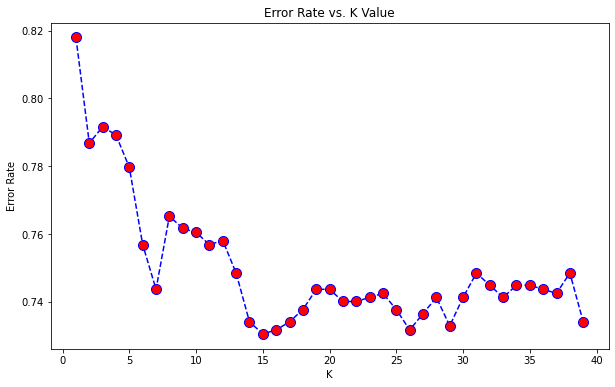

In [84]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Not really improving much beyond 72-74% error rate (26-28% correct). Let's try some different algorithms.

### Linear Regression

In [85]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(x_train, y_train)
print(model.intercept_)
print(model.coef_)

3.573124142682647
[-13.28709408  19.77845923  45.31486145  -0.8275457   -0.9611656
  -0.10371489]


In [86]:
model.score(x_train, y_train)

0.3950846058256896

In [87]:
model.score(x_test, y_test)

0.3947106422544777

39% is definitely heading in the right direction.

### Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression
# Initializing classifier with one-v-rest approach. random_state is # to ensure same results in every execution.
logr = LogisticRegression(multi_class = 'ovr', random_state=3)

# training classifier
logr.fit(x_train, y_train)

# Evaluate the classifier
print(logr.score(x_test, y_test))

0.237125748502994


....and we're back to stinking up the joint all around.

### Polynomial Regression

In [89]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=6)
x_poly = poly_reg.fit_transform(x_train)
pol_reg = LinearRegression()
pol_reg.fit(x_poly, y_train)

pol_reg.score(x_poly, y_train)

0.5340782218248452